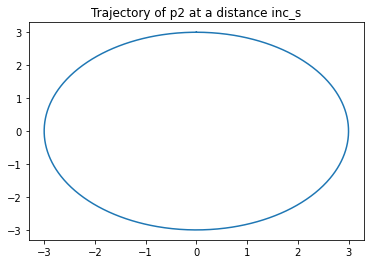

1.0638833445977391
1.06388334459774
1.0638833445979983
1.0638833445976426


TypeError: get_ellip_man() missing 1 required positional argument: 'phi'

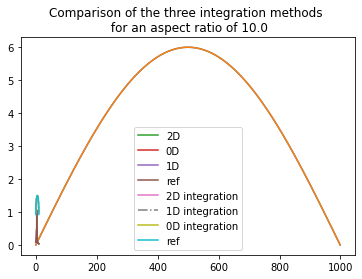

In [1]:

import numpy as np 
import matplotlib.pyplot as plt
import scipy.special as sps
from scipy import integrate
import pdb

#Definition of the qngle variable and the geometry of the cylinder
theta=np.linspace(0,2*np.pi,1000)
R=3

p1=np.array([0,R]) #Fixed point where the integral over p2 is evaluated
p2=np.array([np.sin(theta),np.cos(theta)])*R

#Shows the circumference made by p2
plt.plot(p2[0,:], p2[1,:]); 
plt.title("Trajectory of p2 at a distance inc_s")
plt.show()

dist=p2.copy()
dist[1,:]-=R

C=np.linalg.norm(dist,axis=0)
plt.plot(C)


C=np.sqrt(2*R**2*(1-np.cos(theta))); plt.plot(C)
np.sum(1/C[1:-1])

#IDK what is this 
np.log((np.cos(np.pi/8)+np.sin(np.pi/8))/(np.cos(np.pi/8)-np.sin(np.pi/8)))

def get_ref_integral(inc_s,R):
    """Gets the integral of the fundamental solution at a point of the cylinder
    over the arc of the same cylinder at a distance inc_s
    numerical integral done by the function quad"""
    G = lambda theta :(inc_s**2 + (2*R*np.sin(theta))**2)**-0.5 
    return(integrate.quad(G,0,2*np.pi)[0]*R/(4*np.pi))

def get_ellip(inc_s,R):
    """Provides the elliptic integral of an arc of the same cylinder located at 
    a distance inc_s.
    - k is a constant for the elliptic integral defined by the geometry
    - inc_s > 0, it must not contain a singularity"""
    k=(inc_s**2/(4*R**2)+1)**-0.5
    return(sps.ellipk(k**2)*k/(2*np.pi))

def get_ref_integral2(inc_s,R):
    G = lambda theta :(inc_s**2 + (2*R*np.sin(theta))**2)**-0.5 
    return(integrate.quad(G,0,np.pi/2)[0]*R/np.pi)

def get_ref_integral3(inc_s,R):
    G = lambda theta :(inc_s**2 + 4*R**2-(2*R*np.sin(theta))**2)**-0.5 
    return(integrate.quad(G,0,np.pi/2)[0]*R/np.pi)

def get_ellip_man(inc_s,R,phi):
    """Gets the integral over the square with the singularity on its center 
    - inc_s represents the width of hte arc, and therefore the width of the square"""
    k2=(1+inc_s**2/(4*R**2))**-0.5
    k=(inc_s**2/(4*R**2)+1)**-0.5
    G = lambda theta :(inc_s**2 + 4*R**2*np.sin(theta)**2)**-0.5
    return(integrate.quad(G,phi/2,np.pi*2-phi/2)[0]*R/(4*np.pi))

def get_point_point(inc_s, R):
    """returns the influence of the center line POINT over the wall for an inc_s
    It is mulpiplied by the factor of collapsing an arc to a point, 2*pi*R"""
    return((4*np.pi*(inc_s**2+R**2)**0.5)**-1*2*np.pi*R)

def sing_term2(init, end, x, Rv):
    tau=(end-init)/np.linalg.norm(end-init)
    L=np.linalg.norm(end-init)
    a=x-init
    b=x-end
    s=np.sum(a*tau)
    d=np.linalg.norm(a-tau*np.sum(a*tau))
    
    
    rb=np.linalg.norm(b)
    ra=np.linalg.norm(a)
    G=np.log((rb+L-np.dot(a,tau))/(ra-np.dot(a,tau)))/(4*np.pi)
    return(G)

class cyl_full_integral():
    def __init__(self,axial_disc, L, R):
        
        self.Ns=axial_disc
        self.h=L/self.Ns
        self.s=np.linspace(self.h/2,L-self.h/2,self.Ns)
        self.L=L
        self.R=R
        self.k=np.zeros(self.Ns)
        #arrays to return

    
    def ellip_integral_SL_singular(self):
        """Calculates with the cylindrical tric the singular part over a square 
        with the singularity on its center
        """
        phi=np.arcsin(self.h/(2*self.R)) #Aperture in radians of the square that
                                        #is substracted 
        return(0.44*self.h+get_ellip_man(self.h,self.R, phi))
    
    def ellip_integral_SL_nonsingular(self, inc_s):
        """returns the integral of the arc for non singular arc (inc_s > 0)"""
        k=(inc_s**2/(4*self.R**2)+1)**-0.5
        return(sps.ellipk(k**2)*k/(2*np.pi))

    def get_point_wise_approximation(self,inc_s, R):
        #returns the value of G_ax
        """simply decides wether there is singularity for that inc_s or not
        It returns the G_ax for that given inc_s"""
        if inc_s<=self.h/2:
            return(self.ellip_integral_SL_singular())
        else:
            return(self.ellip_integral_SL_nonsingular(inc_s))
    
    def get_array_point_wise(self):
        F=np.zeros(self.Ns)
        R=self.R
        L=self.L
        for i in range(self.Ns):
            inc_s=self.s[i]-L/2
            F[i]=self.get_point_wise_approximation(inc_s, R)*self.h
        self.F=F
        
    #TO COMPUTE NON INTEGRATED ARRAYS
    
    def not_integrated(self,s_0):
        point_wise=np.zeros(self.Ns)
        ellip_wise=np.zeros(self.Ns)
        Gjerde=np.zeros(self.Ns)
        for i in range(self.Ns):
            #Returns the influence of each arc or point on the centerline. Not integrated
            #since it is not the averaged coefficient
            inc_s=np.linalg.norm(self.s[i]-s_0)
            #pdb.set_trace()
            #Gets the G_ax 
            ellip_wise[i]=self.get_point_wise_approximation(inc_s, self.R)
            #Gets the influence of center line point source
            point_wise[i]=get_point_point(inc_s, self.R)
            
            #To get somewhat of an approximation of the estimation made by the 
            #line integrated formula (Gjerde's formula)
            
            #First, a segment is defined with 
            init=np.array([self.s[i]-self.h/2,0])
            end=np.array([self.s[i]+self.h/2,0])
            Gjerde[i]=sing_term2(init, end, np.array([s_0, self.R]), R)*2*np.pi*R
            
        self.ellip_point=ellip_wise
        self.point_point=point_wise
        self.Gjerde=Gjerde
        return()
    
    #INTEGRATION FUNCTIONS
    def integrate_0D(self):
        #Integrates the 0D approximation at the vessel wall
        F_point=np.zeros(self.Ns)
        R=self.R
        L=self.L
        for i in range(self.Ns):
            si=self.s[i]
            for j in range(self.Ns):
                sj=self.s[j]
                inc_s=np.abs(sj-si)
                F_point[i]+=get_point_point(inc_s,R)*self.h
        self.SL_0D=F_point
    
    def integrate_2D(self):
        #Integrates the 2D approximation at the vessel wall
        self.SL_2D=np.zeros(self.Ns)
        for i in range(self.Ns):
            si=self.s[i]
            for j in range(self.Ns):
                sj=self.s[j]
                self.SL_2D[i]+=self.get_point_wise_approximation(np.abs(si-sj), R)*self.h
                
    def integrate_1D(self):
        #Returns the analytically integrated value of the 1D approximation
        L=self.L
        R=self.R
        self.SL_1D=np.zeros(self.Ns)
        
        for i in range(self.Ns): 
            #pdb.set_trace()
            si=self.s[i]
            init=np.array([0,0])
            end=np.array([0,L])
            x=np.array([R,si])
            #pdb.set_trace()
            pp=sing_term2(init, end, x, R)*2*np.pi*R
            self.SL_1D[i]=pp
                    

                    
class line_full_integral():
    """Returns the Gjerde like line integration
    Since the formula implicitly integrates the whole line there is no 
    point wise approximation"""
    def __init__(self,axial_disc, L, R):
        self.Ns=axial_disc
        self.h=L/self.Ns
        self.s=np.linspace(self.h/2,L-self.h/2,self.Ns)
        self.L=L
        self.R=R
        #arrays to return
        self.SL=np.zeros(self.Ns, dtype=float)
        self.DL=np.zeros(self.Ns)

#%%
R=0.5
L=10
#%% - Reference solution
ref=cyl_full_integral(1000,L,R)


#%%
ref.not_integrated(0.3*L)
ref_point=ref.ellip_point

ref.integrate_2D()
ref_SL=ref.SL_2D
#%%
N=30
#%%
t=cyl_full_integral(N,L,R)

  
u=line_full_integral(N,L,R)

t.not_integrated(0.3*L)
plt.plot(t.s,t.ellip_point, label="2D"); 
plt.plot(t.s,t.point_point, label="0D"); 
plt.plot(t.s,t.Gjerde/t.h, label="1D");
plt.plot(ref.s,ref_point, label="ref")
plt.title("Comparison of the three integration methods \n for an aspect ratio of {}".format((L/(2*R))))
plt.legend()
#%%

t.integrate_0D()
t.integrate_1D()
t.integrate_2D()
#%%
#Even with the 2 dipole is added there is a 20% difference???
plt.plot(t.s,t.SL_2D,label="2D integration")
plt.plot(t.s,t.SL_1D,'-.' ,label="1D integration")
plt.plot(t.s,t.SL_0D, label='0D integration')
plt.plot(ref.s,ref_SL, label="ref")

plt.legend()
#%%        

err=np.zeros(0)
for i in np.linspace(0.01,1,100):
    inc_s=i
    R=1
    print(get_ref_integral(inc_s,R))
    print(get_ref_integral2(inc_s,R))
    print(get_ref_integral3(inc_s,R))
    print(get_ellip(inc_s,R))
    print(get_ellip_man(inc_s,R),"\n")
    k=(inc_s**2/(4*R**2)+1)**-0.5
    err=np.append(err, (get_ellip(inc_s,R)-get_ellip_man(inc_s,R))/get_ellip(inc_s,R))
    
def get_k(inc_s, R):
    return((inc_s**2/(4*R**2)+1)**-0.5)
    
#%%
    
def integral_along_cylinder(L,pos_or, R, disc_axial):
    s=np.linspace(-L+pos_or*L+L/(2*disc_axial),L-pos_or*L-L/(2*disc_axial), disc_axial)
    pos=np.argmin((s-L*pos_or)**2)
    s=np.delete(s,pos)
    c=0
    inc_s=L/disc_axial
    pdb.set_trace()
    F=np.zeros(len(theta))
    for i in s:
        k=(i**2/(4*R**2)+1)**-0.5
        F[c]=k*sps.ellipk(k**2)/(2*np.pi)
        c+=1
    return(F)
    

# =============================================================================
# def singular_single_layer(L,disc_axial,R):
#     
# 
# a=integral_along_cylinder(10,0.25,1,1000)
# plt.plot(a)
# plt.title("F(s)")
# =============================================================================
